In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.callbacks import EarlyStopping
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Xiaomi_clean.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.600000,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.000000,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.500000,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.400000,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.600000,21.799999,19.520000,21.450001,21.450001,364065075
...,...,...,...,...,...,...,...
1795,2025-10-22,46.000000,46.740002,45.700001,46.340000,46.340000,121391262
1796,2025-10-23,46.020000,47.080002,45.700001,46.740002,46.740002,106829656
1797,2025-10-24,47.099998,47.400002,45.740002,45.919998,45.919998,170946122
1798,2025-10-27,45.720001,46.000000,43.880001,45.799999,45.799999,282836746


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df_Close = df[['Close']].reset_index(drop=True)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_Close)

In [5]:
n = len(data_scaled)
train_size = int(0.7 * n)
val_size = int(0.1 * n)

train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:train_size + val_size]
test_data = data_scaled[train_size + val_size:]

In [6]:
def create_dataset(dataset, time_step, prev_data=None):
    """
    Return X (num_samples, time_step) and y (num_samples,)
    If prev_data provided, it's concatenated to the left of dataset so
    the first windows can include historical points.
    """
    if prev_data is not None and len(prev_data) > 0:
        dataset = np.concatenate((prev_data, dataset), axis=0)
    X, y = [], []
    for i in range(0, len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [7]:
def build_gru_model(time_step, units=50, dropout=0.2, optimizer='adam'):
    model = Sequential()
    model.add(GRU(units, input_shape=(time_step, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [8]:
param_distributions = {
    'model__units': [50, 100],
    'model__dropout': [0.1, 0.2, 0.3],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [100]  # EarlyStopping will usually stop earlier
}
time_step_grid = [30, 50, 60]   # reduced grid for speed


In [9]:
best_mape = float('inf')
best_model = None
best_params = None
best_time_step = None

In [10]:
tscv = TimeSeriesSplit(n_splits=3)

print("Starting hyperparameter tuning...\n")
for time_step in time_step_grid:
    print(f"Evaluating time_step = {time_step}...")

    # prepare datasets
    X_train, y_train = create_dataset(train_data, time_step)
    last_train = train_data[-time_step:] if len(train_data) >= time_step else train_data.copy()
    X_val, y_val = create_dataset(val_data, time_step, prev_data=last_train)

    if X_train.size == 0 or X_val.size == 0:
        print(f"  Skipping time_step={time_step}: not enough data (X_train {X_train.shape}, X_val {X_val.shape})")
        continue

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    base_model = KerasRegressor(
        model=partial(build_gru_model, time_step=time_step),
        verbose=0
    )

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=4,
        cv=tscv,
        verbose=1,
        n_jobs=1,
        random_state=42
    )

    try:
        search.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        )
    except Exception as e:
        print(f"  Search failed for time_step={time_step}: {e}")
        continue

    # evaluate on validation (the X_val we created)
    y_pred = search.best_estimator_.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    print(f"  Val MAPE: {mape:.6f} | Best params: {search.best_params_}\n")

    if mape < best_mape:
        best_mape = mape
        # extract compiled keras model from scikeras wrapper
        best_model = search.best_estimator_.model
        best_params = search.best_params_
        best_time_step = time_step

if best_time_step is None:
    raise RuntimeError("No valid time_step found during tuning. Reduce time_step_grid or ensure enough data.")

Starting hyperparameter tuning...

Evaluating time_step = 30...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Val MAPE: 0.050525 | Best params: {'model__units': 50, 'model__optimizer': 'adam', 'model__dropout': 0.1, 'epochs': 100, 'batch_size': 32}

Evaluating time_step = 50...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Val MAPE: 0.053128 | Best params: {'model__units': 50, 'model__optimizer': 'adam', 'model__dropout': 0.1, 'epochs': 100, 'batch_size': 32}

Evaluating time_step = 60...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Val MAPE: 0.050178 | Best params: {'model__units': 50, 'model__optimizer': 'adam', 'model__dropout': 0.3, 'epochs': 100, 'batch_size': 32}



In [11]:
print("Training final model with best parameters...")
combined = np.concatenate((train_data, val_data), axis=0)
X_train_full, y_train_full = create_dataset(combined, best_time_step)
X_train_full = X_train_full.reshape(X_train_full.shape[0], X_train_full.shape[1], 1)

final_model = build_gru_model(
    time_step=best_time_step,
    units=best_params['model__units'],
    dropout=best_params['model__dropout'],
    optimizer=best_params['model__optimizer']
)
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
final_model.fit(X_train_full, y_train_full,
                epochs=100,
                batch_size=best_params.get('batch_size', 32),
                callbacks=[early_stop],
                verbose=1)

Training final model with best parameters...
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0074
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.6759e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.2246e-04
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7.6151e-04
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.0947e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.0496e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.5159e-04
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.5154e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.8330e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.8490e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.9535e-04
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.2246e-04
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.3439e-04
Epoch 14/100
44/44 ━━━━━━━━━━━━━

In [12]:
print("Predicting validation segment for visualization...")

last_train_points = train_data[-best_time_step:]
X_val_plot, y_val_plot = create_dataset(val_data, best_time_step, prev_data=last_train_points)
X_val_plot = X_val_plot.reshape(X_val_plot.shape[0], X_val_plot.shape[1], 1)

y_pred_val = final_model.predict(X_val_plot)
y_val_inv = scaler.inverse_transform(y_val_plot.reshape(-1, 1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))


Predicting validation segment for visualization...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


In [13]:
last_val = combined[-best_time_step:] if len(combined) >= best_time_step else combined.copy()
X_test, y_test = create_dataset(test_data, best_time_step, prev_data=last_val)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_pred_test = final_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [14]:
test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
test_msle = mean_squared_log_error(y_test_inv, y_pred_test_inv)

print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Best time_step : {best_time_step}")
print(f"Best MAPE (val): {best_mape:.6f}")
print(f"Test MAPE      : {test_mape:.6f}")
print(f"Test RMSE      : {test_rmse:.2f}")
print(f"Test MSLE      : {test_msle:.6f}")
print(f"Best params    : {best_params}")
print("="*50)


FINAL RESULTS
Best time_step : 60
Best MAPE (val): 0.050178
Test MAPE      : 0.022631
Test RMSE      : 1.30
Test MSLE      : 0.000903
Best params    : {'model__units': 50, 'model__optimizer': 'adam', 'model__dropout': 0.3, 'epochs': 100, 'batch_size': 32}


In [15]:
print("\nPredicting next 30 days...")
seed_input = test_data[-best_time_step:].flatten() if len(test_data) >= best_time_step else np.concatenate((combined, test_data))[-best_time_step:].flatten()
temp_input = list(seed_input)
lst_output = []
for i in range(30):
    x_in = np.array(temp_input[-best_time_step:]).reshape(1, best_time_step, 1)
    y_pred = final_model.predict(x_in, verbose=0)[0, 0]
    temp_input.append(y_pred)
    lst_output.append(y_pred)

lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
for i, price in enumerate(lst_output):
    print(f"Day {i+1}: {price[0]:.2f}")



Predicting next 30 days...
Day 1: 44.86
Day 2: 44.60
Day 3: 44.38
Day 4: 44.19
Day 5: 44.01
Day 6: 43.84
Day 7: 43.66
Day 8: 43.48
Day 9: 43.30
Day 10: 43.12
Day 11: 42.94
Day 12: 42.76
Day 13: 42.58
Day 14: 42.41
Day 15: 42.23
Day 16: 42.06
Day 17: 41.89
Day 18: 41.72
Day 19: 41.55
Day 20: 41.38
Day 21: 41.22
Day 22: 41.06
Day 23: 40.90
Day 24: 40.75
Day 25: 40.60
Day 26: 40.44
Day 27: 40.30
Day 28: 40.15
Day 29: 40.00
Day 30: 39.86


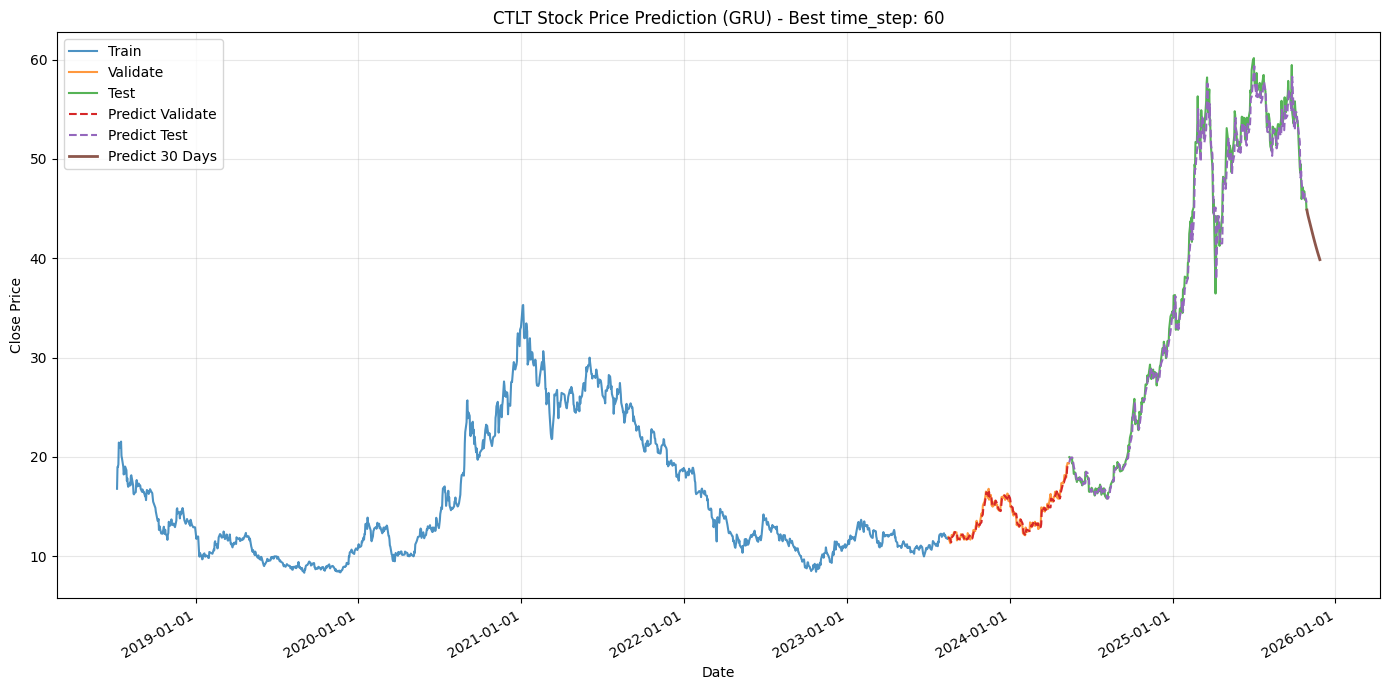

In [16]:
train_index = df.index[:train_size]      
val_index = df.index[train_size:train_size + val_size]
test_index = df.index[train_size + val_size:]
predict_30_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(14, 7))
plt.plot(train_index, scaler.inverse_transform(train_data), label='Train', alpha=0.8)
plt.plot(val_index, scaler.inverse_transform(val_data), label='Validate', alpha=0.8)
plt.plot(test_index, scaler.inverse_transform(test_data), label='Test', alpha=0.8)
plt.plot(val_index[:len(y_pred_val_inv)], y_pred_val_inv, '--', label='Predict Validate')
plt.plot(test_index[:len(y_pred_test_inv)], y_pred_test_inv, '--', label='Predict Test')
plt.plot(predict_30_index, lst_output, label='Predict 30 Days', linewidth=2)
plt.title(f'CTLT Stock Price Prediction (GRU) - Best time_step: {best_time_step}')
plt.xlabel('Date'); plt.ylabel('Close Price'); plt.legend(); plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()